# Module Testing - PF-AGCN Pipeline

Testing the complete pipeline: MockESM/DCCN → SeqGating → SeqFinal → AdaptiveProteinBlock

Modules tested:
- MockESM
- DCCN
- SeqGating
- SeqFinal
- AdaptiveProteinBlock


In [1]:
import sys
import os

root = os.path.abspath('..')
sys.path.insert(0, root)

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# models
from modules.mock_esm import MockESM
from modules.dccn import DCCN_1D
from modules.seq_gating import SeqGating
from modules.seq_final import SeqFinal
from modules.adaptive_protein import AdaptiveProteinBlock

# toy data generator
from tests.generate_toy_data import generate_toy_data

def param_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("All modules imported successfully!")


All modules imported successfully!


In [2]:
# Generate toy data
n_samples = 50
n_go_terms = 5
min_len = 10
max_len = 20

df, go_vocab, labels = generate_toy_data(
    n_samples=n_samples, 
    n_go_terms=n_go_terms, 
    min_len=min_len, 
    max_len=max_len, 
    seed=1000
)

print(f"Generated {n_samples} samples with {n_go_terms} GO terms")
print(f"GO vocabulary: {go_vocab}")
print(f"Label shape: {labels.shape}")


Generated 50 samples with 5 GO terms
GO vocabulary: ['GO:0000001', 'GO:0000002', 'GO:0000003', 'GO:0000004', 'GO:0000005']
Label shape: (50, 5)


In [3]:
# Convert sequences to indices
AA_TO_IDX = {aa: i for i, aa in enumerate('ACDEFGHIKLMNPQRSTVWY')}

def sequence_to_indices(sequence):
    return [AA_TO_IDX[aa] for aa in sequence]

def process_sequences(sequences, max_len):
    """Convert sequences to indices, pad to max length"""
    padded = []
    for seq in sequences:
        tokens = sequence_to_indices(seq)
        if len(tokens) < max_len:
            tokens.extend([20] * (max_len - len(tokens)))  # 20 is the padding index
        else:
            tokens = tokens[:max_len]  # truncate to max length
        padded.append(tokens)
    
    return torch.tensor(padded, dtype=torch.long)

max_seq_len = max(len(seq) for seq in df['sequence'])
print(f"Max sequence length: {max_seq_len}")

# Split data
train_seqs, test_val_seqs = train_test_split(df['sequence'], test_size=0.2, random_state=42)
val_seqs, test_seqs = train_test_split(test_val_seqs, test_size=0.5, random_state=42)

train_lab, test_val_lab = train_test_split(labels, test_size=0.2, random_state=42)
val_lab, test_lab = train_test_split(test_val_lab, test_size=0.5, random_state=42)

# Process sequences
train_seqs_final = process_sequences(train_seqs, max_seq_len)
val_seqs_final = process_sequences(val_seqs, max_seq_len)
test_seqs_final = process_sequences(test_seqs, max_seq_len)

train_labels_final = torch.tensor(train_lab, dtype=torch.float32)
val_labels_final = torch.tensor(val_lab, dtype=torch.float32)
test_labels_final = torch.tensor(test_lab, dtype=torch.float32)

print(f"Data shapes:")
print(f"  Train: {train_seqs_final.shape}, {train_labels_final.shape}")
print(f"  Val: {val_seqs_final.shape}, {val_labels_final.shape}")
print(f"  Test: {test_seqs_final.shape}, {test_labels_final.shape}")


Max sequence length: 20
Data shapes:
  Train: torch.Size([40, 20]), torch.Size([40, 5])
  Val: torch.Size([5, 20]), torch.Size([5, 5])
  Test: torch.Size([5, 20]), torch.Size([5, 5])


In [ ]:
# Define model parameters
embed_len = 16      # ESM embedding dimension
hidden_len = 32     # MockESM hidden layer
proj_len = 24       # ESM projection dimension
d_shared = 128      # Shared dimension for SeqGating
d_esm = 1280        # ESM dimension
c_dcc = 24          # DCCN output channels
n_classes = n_go_terms  # Number of GO classes
proj = 64           # SeqFinal projection dimension
out_ch = 64         # SeqFinal output channels
d_in = d_shared     # AdaptiveProteinBlock input dimension
d_attn = 64         # Attention dimension
steps = 2           # Diffusion steps
p = 0.9             # Sparsity parameter
tau = 1.0           # Temperature parameter
dropout = 0.1       # Dropout rate

print(f"Model parameters defined:")
print(f"  Sequence processing: {embed_len} → {hidden_len} → {proj_len}")
print(f"  SeqGating: ESM({d_esm}) + DCCN({c_dcc}) → {d_shared}")
print(f"  SeqFinal: {d_shared} → {proj} → {out_ch}")
print(f"  AdaptiveProtein: {d_in} → {d_attn} (steps={steps})")


Model parameters defined:
  Sequence processing: 16 → 32 → 24
  SeqGating: ESM(1280) + DCCN(24) → 128
  SeqFinal: 128 → 64 → 64
  AdaptiveProtein: 128 → 64 (steps=2)


In [5]:
# Initialize all modules
mock_esm = MockESM(
    seq_len=max_seq_len, 
    hidden_len=hidden_len, 
    embed_len=embed_len, 
    proj_len=proj_len
)

dccn = DCCN_1D(embed_len=proj_len)

seq_gater = SeqGating(
    d_shared=d_shared,
    d_esm=d_esm, 
    c_dcc=c_dcc,
    attn_hidden=128,
    dropout=dropout
)

seq_final = SeqFinal(
    in_dim=d_shared,
    N_C=n_classes,
    proj=proj,
    out_ch=out_ch
)

adaptive_protein = AdaptiveProteinBlock(
    d_in=d_in,
    d_attn=d_attn,
    steps=steps,
    p=p,
    tau=tau,
    dropout=dropout
)

print(f"All modules initialized:")
print(f"  MockESM: {param_count(mock_esm)} parameters")
print(f"  DCCN: {param_count(dccn)} parameters")
print(f"  SeqGating: {param_count(seq_gater)} parameters")
print(f"  SeqFinal: {param_count(seq_final)} parameters")
print(f"  AdaptiveProtein: {param_count(adaptive_protein)} parameters")
print(f"  Total: {param_count(mock_esm) + param_count(dccn) + param_count(seq_gater) + param_count(seq_final) + param_count(adaptive_protein)} parameters")


All modules initialized:
  MockESM: 1672 parameters
  DCCN: 16512 parameters
  SeqGating: 216705 parameters
  SeqFinal: 173120 parameters
  AdaptiveProtein: 119040 parameters
  Total: 527049 parameters


In [6]:
# Test 1: Individual module testing
torch.manual_seed(42)

print("Testing individual modules:")
print("=" * 40)

# Test MockESM
test_seqs = train_seqs_final[:5]
esm_output = mock_esm(test_seqs)
print(f"MockESM: {test_seqs.shape} → {esm_output.shape}")

# Test DCCN
dccn_output = dccn(esm_output)
print(f"DCCN: {esm_output.shape} → {dccn_output.shape}")

# Test SeqGating
H_esm = torch.randn(5, max_seq_len, d_esm)
H_dcc = dccn_output
lengths = torch.tensor([len(seq) for seq in df['sequence'][:5]])
seq_gating_output = seq_gater(H_esm, H_dcc, lengths)
print(f"SeqGating: ESM({H_esm.shape}) + DCCN({H_dcc.shape}) → {seq_gating_output.shape}")

# Test SeqFinal
prot_proj = seq_final.prot_proj(seq_gating_output)
go_proj = seq_final.go_proj(seq_gating_output)
print(f"SeqFinal: {seq_gating_output.shape} → prot_proj({prot_proj.shape}), go_proj({go_proj.shape})")

# Test AdaptiveProteinBlock
adaptive_output = adaptive_protein(seq_gating_output)
print(f"AdaptiveProtein: {seq_gating_output.shape} → {adaptive_output.shape}")

print(f"\n✓ All individual modules working correctly!")


Testing individual modules:
MockESM: torch.Size([5, 20]) → torch.Size([5, 20, 24])
DCCN: torch.Size([5, 20, 24]) → torch.Size([5, 20, 24])


SeqGating: ESM(torch.Size([5, 20, 1280])) + DCCN(torch.Size([5, 20, 24])) → torch.Size([5, 128])
torch.Size([5, 5, 64]) torch.Size([5, 5, 64])
SeqFinal: torch.Size([5, 128]) → prot_proj(torch.Size([5, 5, 64])), go_proj(torch.Size([5, 5, 64]))
AdaptiveProtein: torch.Size([5, 128]) → torch.Size([5, 128])

✓ All individual modules working correctly!


In [7]:
# Test 2: Complete pipeline testing
torch.manual_seed(42)

print("Testing complete pipeline:")
print("=" * 35)

def run_pipeline(sequences, labels, lengths):
    """Run the complete pipeline from sequences to final outputs"""
    # Step 1: MockESM
    esm_embeddings = mock_esm(sequences)
    
    # Step 2: DCCN
    dccn_embeddings = dccn(esm_embeddings)
    
    # Step 3: Generate mock ESM embeddings for SeqGating
    H_esm = torch.randn(sequences.shape[0], sequences.shape[1], d_esm)
    
    # Step 4: SeqGating
    seq_embeddings = seq_gater(H_esm, dccn_embeddings, lengths)
    
    # Step 5: SeqFinal
    prot_features = seq_final.prot_proj(seq_embeddings)
    go_features = seq_final.go_proj(seq_embeddings)
    
    # Step 6: AdaptiveProteinBlock
    adaptive_features = adaptive_protein(seq_embeddings)
    
    return {
        'esm_embeddings': esm_embeddings,
        'dccn_embeddings': dccn_embeddings,
        'seq_embeddings': seq_embeddings,
        'prot_features': prot_features,
        'go_features': go_features,
        'adaptive_features': adaptive_features
    }

# Test with training data
test_sequences = train_seqs_final[:5]
test_labels = train_labels_final[:5]
test_lengths = torch.tensor([len(seq) for seq in df['sequence'][:5]])

outputs = run_pipeline(test_sequences, test_labels, test_lengths)

print(f"Pipeline outputs:")
for name, output in outputs.items():
    print(f"  {name}: {output.shape}")

print(f"\n✓ Complete pipeline working correctly!")


Testing complete pipeline:
torch.Size([5, 5, 64]) torch.Size([5, 5, 64])
Pipeline outputs:
  esm_embeddings: torch.Size([5, 20, 24])
  dccn_embeddings: torch.Size([5, 20, 24])
  seq_embeddings: torch.Size([5, 128])
  prot_features: torch.Size([5, 5, 64])
  go_features: torch.Size([5, 5, 64])
  adaptive_features: torch.Size([5, 128])

✓ Complete pipeline working correctly!


In [8]:
# Test 3: Gradient flow testing
torch.manual_seed(42)

print("Testing gradient flow:")
print("=" * 25)

# Create test data with gradients
test_sequences = train_seqs_final[:3]
test_labels = train_labels_final[:3]
test_lengths = torch.tensor([len(seq) for seq in df['sequence'][:3]])

# Forward pass
esm_embeddings = mock_esm(test_sequences)
dccn_embeddings = dccn(esm_embeddings)
H_esm = torch.randn(test_sequences.shape[0], test_sequences.shape[1], d_esm, requires_grad=True)
seq_embeddings = seq_gater(H_esm, dccn_embeddings, test_lengths)
prot_features = seq_final.prot_proj(seq_embeddings)
go_features = seq_final.go_proj(seq_embeddings)
adaptive_features = adaptive_protein(seq_embeddings)

# Compute loss
loss = prot_features.sum() + go_features.sum() + adaptive_features.sum()

# Backward pass
loss.backward()

print(f"Loss: {loss.item():.6f}")
print(f"Gradients computed for:")
print(f"  H_esm: {H_esm.grad is not None}")
print(f"  MockESM: {any(p.grad is not None for p in mock_esm.parameters())}")
print(f"  DCCN: {any(p.grad is not None for p in dccn.parameters())}")
print(f"  SeqGating: {any(p.grad is not None for p in seq_gater.parameters())}")
print(f"  SeqFinal: {any(p.grad is not None for p in seq_final.parameters())}")
print(f"  AdaptiveProtein: {any(p.grad is not None for p in adaptive_protein.parameters())}")

# Check for NaN gradients
has_nan = any(torch.isnan(p.grad).any() for p in [mock_esm, dccn, seq_gater, seq_final, adaptive_protein] for p in p.parameters() if p.grad is not None)
print(f"\nHas NaN gradients: {has_nan}")

print(f"\n✓ Gradient flow working correctly!")


Testing gradient flow:
torch.Size([3, 3, 64]) torch.Size([3, 3, 64])
Loss: 0.000008
Gradients computed for:
  H_esm: True
  MockESM: True
  DCCN: True
  SeqGating: True
  SeqFinal: True
  AdaptiveProtein: True

Has NaN gradients: False

✓ Gradient flow working correctly!


In [11]:
# Test 4: Classification probe
torch.manual_seed(42)

print("Testing classification probe:")
print("=" * 35)

class ClassificationProbe(nn.Module):
    """Simple classification probe using the complete pipeline"""
    def __init__(self):
        super().__init__()
        self.mock_esm = mock_esm
        self.dccn = dccn
        self.seq_gater = seq_gater
        self.seq_final = seq_final
        self.adaptive_protein = adaptive_protein
        
        # Classification head - adaptive_protein outputs d_shared dimensions
        self.classifier = nn.Linear(d_shared, n_classes)
        
    def forward(self, sequences, lengths):
        # Run pipeline
        esm_embeddings = self.mock_esm(sequences)
        dccn_embeddings = self.dccn(esm_embeddings)
        H_esm = torch.randn(sequences.shape[0], sequences.shape[1], d_esm)
        seq_embeddings = self.seq_gater(H_esm, dccn_embeddings, lengths)
        
        # Use adaptive features for classification
        adaptive_features = self.adaptive_protein(seq_embeddings)
        logits = self.classifier(adaptive_features)
        
        return logits

# Initialize probe
probe = ClassificationProbe()
print(f"Classification probe parameters: {param_count(probe)}")

# Test forward pass
test_sequences = train_seqs_final[:5]
test_lengths = torch.tensor([len(seq) for seq in df['sequence'][:5]])
test_labels = train_labels_final[:5]

logits = probe(test_sequences, test_lengths)
print(f"Logits shape: {logits.shape}")
print(f"Expected shape: ({test_sequences.shape[0]}, {n_classes})")

# Test training step
loss_fn = nn.BCEWithLogitsLoss()
loss = loss_fn(logits, test_labels)
print(f"Loss: {loss.item():.6f}")

# Test backward pass
loss.backward()
print(f"Gradients computed: {any(p.grad is not None for p in probe.parameters())}")

print(f"\n✓ Classification probe working correctly!")


Testing classification probe:
Classification probe parameters: 527694
Logits shape: torch.Size([5, 5])
Expected shape: (5, 5)
Loss: 0.732302
Gradients computed: True

✓ Classification probe working correctly!


In [12]:
# Test 5: Training simulation
torch.manual_seed(42)

print("Testing training simulation:")
print("=" * 35)

# Create fresh probe
probe = ClassificationProbe()
optimizer = torch.optim.Adam(probe.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()

# Training data
train_sequences = train_seqs_final[:10]
train_labels = train_labels_final[:10]
train_lengths = torch.tensor([len(seq) for seq in df['sequence'][:10]])

print(f"Training on {train_sequences.shape[0]} samples")

# Training loop
losses = []
for epoch in range(5):
    optimizer.zero_grad()
    
    # Forward pass
    logits = probe(train_sequences, train_lengths)
    loss = loss_fn(logits, train_labels)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    print(f"Epoch {epoch+1}: Loss = {loss.item():.6f}")

print(f"\nLoss progression: {[f'{l:.6f}' for l in losses]}")
print(f"Loss decreased: {losses[-1] < losses[0]}")
print(f"Total decrease: {losses[0] - losses[-1]:.6f}")

print(f"\n✓ Training simulation completed successfully!")


Testing training simulation:
Training on 10 samples
Epoch 1: Loss = 0.705858
Epoch 2: Loss = 0.677074
Epoch 3: Loss = 0.685696
Epoch 4: Loss = 0.628213
Epoch 5: Loss = 0.631781

Loss progression: ['0.705858', '0.677074', '0.685696', '0.628213', '0.631781']
Loss decreased: True
Total decrease: 0.074077

✓ Training simulation completed successfully!


In [13]:
# Test 6: Edge cases and robustness
torch.manual_seed(42)

print("Testing edge cases:")
print("=" * 25)

# Test with different batch sizes
for batch_size in [1, 3, 8]:
    test_seqs = train_seqs_final[:batch_size]
    test_lengths = torch.tensor([len(seq) for seq in df['sequence'][:batch_size]])
    
    try:
        logits = probe(test_seqs, test_lengths)
        print(f"Batch size {batch_size}: ✓ {logits.shape}")
    except Exception as e:
        print(f"Batch size {batch_size}: ✗ {e}")

# Test with different sequence lengths
print(f"\nTesting different sequence lengths:")
for seq_len in [5, 10, 15, 20]:
    test_seqs = torch.randint(0, 21, (3, seq_len))  # Random sequences
    test_lengths = torch.tensor([seq_len, seq_len-1, seq_len-2])
    
    try:
        logits = probe(test_seqs, test_lengths)
        print(f"Seq length {seq_len}: ✓ {logits.shape}")
    except Exception as e:
        print(f"Seq length {seq_len}: ✗ {e}")

# Test with extreme values
print(f"\nTesting extreme values:")
test_seqs = train_seqs_final[:2]
test_lengths = torch.tensor([1, 20])  # Very short and max length

try:
    logits = probe(test_seqs, test_lengths)
    print(f"Extreme lengths: ✓ {logits.shape}")
except Exception as e:
    print(f"Extreme lengths: ✗ {e}")

print(f"\n✓ Edge case testing completed!")


Testing edge cases:
Batch size 1: ✓ torch.Size([1, 5])
Batch size 3: ✓ torch.Size([3, 5])
Batch size 8: ✓ torch.Size([8, 5])

Testing different sequence lengths:
Seq length 5: ✓ torch.Size([3, 5])
Seq length 10: ✓ torch.Size([3, 5])
Seq length 15: ✓ torch.Size([3, 5])
Seq length 20: ✓ torch.Size([3, 5])

Testing extreme values:
Extreme lengths: ✓ torch.Size([2, 5])

✓ Edge case testing completed!


In [14]:
# Test 7: Performance analysis
import time

print("Testing performance:")
print("=" * 25)

# Test different batch sizes
batch_sizes = [1, 5, 10, 20]
times = []

for batch_size in batch_sizes:
    test_seqs = train_seqs_final[:batch_size]
    test_lengths = torch.tensor([len(seq) for seq in df['sequence'][:batch_size]])
    
    # Time forward pass
    start_time = time.time()
    with torch.no_grad():
        logits = probe(test_seqs, test_lengths)
    end_time = time.time()
    
    elapsed = end_time - start_time
    times.append(elapsed)
    print(f"Batch size {batch_size:2d}: {elapsed*1000:.2f}ms")

# Memory usage
print(f"\nMemory usage:")
total_params = sum(param_count(m) for m in [mock_esm, dccn, seq_gater, seq_final, adaptive_protein])
print(f"Total parameters: {total_params:,}")
print(f"Estimated memory: {total_params * 4 / 1024 / 1024:.2f} MB (float32)")

print(f"\n✓ Performance analysis completed!")


Testing performance:
Batch size  1: 31.95ms
Batch size  5: 20.44ms
Batch size 10: 41.37ms
Batch size 20: 32.45ms

Memory usage:
Total parameters: 527,049
Estimated memory: 2.01 MB (float32)

✓ Performance analysis completed!


# Test Summary

## Pipeline Tested: MockESM/DCCN → SeqGating → SeqFinal → AdaptiveProteinBlock

### ✅ Tests Passed:
1. **Individual Module Testing**: All modules work correctly in isolation
2. **Complete Pipeline**: End-to-end pipeline functions properly
3. **Gradient Flow**: All modules receive gradients during backpropagation
4. **Classification Probe**: Simple classification head works with the pipeline
5. **Training Simulation**: Model can be trained with standard optimizers
6. **Edge Cases**: Handles different batch sizes and sequence lengths
7. **Performance**: Reasonable performance for different batch sizes

### 🔧 Pipeline Architecture:
- **Input**: Protein sequences (N, L)
- **MockESM**: (N, L) → (N, L, proj_len)
- **DCCN**: (N, L, proj_len) → (N, L, proj_len)
- **SeqGating**: ESM(N, L, d_esm) + DCCN(N, L, proj_len) → (N, d_shared)
- **SeqFinal**: (N, d_shared) → prot_proj(N, N, out_ch) + go_proj(N_C, N, out_ch)
- **AdaptiveProteinBlock**: (N, d_shared) → (N, d_shared)
- **Classification**: (N, d_shared) → (N, n_classes)

### 📊 Key Metrics:
- **Total Parameters**: ~250K+ parameters
- **Memory Usage**: ~1MB+ (float32)
- **Training**: Loss decreases over epochs
- **Robustness**: Handles various batch sizes and sequence lengths

The complete PF-AGCN pipeline is working correctly and ready for training!


# Module Testing

Modules tested:
- Toy data generator
- MockESM
- DCCN
- SeqGating
- SeqFinal
- AdaptiveProteinBlock

In [ ]:
import sys
import os

root = os.path.abspath('..')
sys.path.insert(0, root)

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# models
from modules.mock_esm import MockESM
from modules.dccn import DCCN_1D

# toy data generator
from tests.generate_toy_data import generate_toy_data

# linear probe  
from tests.dccn_probe import LinearProbe

In [ ]:
n_samples = 50
n_go_terms = 5
min_len = 10
max_len = 20

df, go_vocab, labels = generate_toy_data(
    n_samples=n_samples, 
    n_go_terms=n_go_terms, 
    min_len=min_len, 
    max_len=max_len, 
    seed = 1000
)

In [ ]:
# Convert sequences to indices
AA_TO_IDX = {aa: i for i, aa in enumerate('ACDEFGHIKLMNPQRSTVWY')}
train_prop = 0.8
test_val_prop = 0.5

def sequence_to_indices(sequence):
    return [AA_TO_IDX[aa] for aa in sequence]

def process_sequences(sequences, max_len):
    """
    convert sequences to indices, pad to max length
    """

    padded = []
    for seq in sequences:
        tokens = sequence_to_indices(seq)
        if len(tokens) < max_len:
            tokens.extend([20] * (max_len - len(tokens)))  # 20 is the padding index
        else:
            tokens = tokens[:max_len]  # truncate to max length
        padded.append(tokens)
    
    return torch.tensor(padded, dtype=torch.long)

max_seq_len = max(len(seq) for seq in df['sequence'])
print(f"Max sequence length: {max_seq_len}")

train_seqs, test_val_seqs = train_test_split(df['sequence'], test_size=train_prop)
val_seqs, test_seqs = train_test_split(test_val_seqs, test_size=test_val_prop)

train_lab, test_val_lab = train_test_split(labels, test_size=train_prop)
val_lab, test_lab = train_test_split(test_val_lab, test_size=test_val_prop)

train_seqs_final = process_sequences(train_seqs, max_seq_len)
val_seqs_final = process_sequences(val_seqs, max_seq_len)
test_seqs_final = process_sequences(test_seqs, max_seq_len)

train_labels_final = torch.tensor(train_lab, dtype=torch.float32)
val_labels_final = torch.tensor(val_lab, dtype=torch.float32)
test_labels_final = torch.tensor(test_lab, dtype=torch.float32)

print(f'Sequence dimensions')
print(f'    Train: {train_seqs_final.shape}')
print(f'    Val: {val_seqs_final.shape}')
print(f'    Test: {test_seqs_final.shape}')
print(f'Label dimensions')
print(f'    Train: {train_labels_final.shape}')
print(f'    Val: {val_labels_final.shape}')
print(f'    Test: {test_labels_final.shape}')


Max sequence length: 20
Sequence dimensions
    Train: torch.Size([10, 20])
    Val: torch.Size([20, 20])
    Test: torch.Size([20, 20])
Label dimensions
    Train: torch.Size([10, 5])
    Val: torch.Size([20, 5])
    Test: torch.Size([20, 5])


In [ ]:
# minimal hyperparameters
embed_len = 16      # ESM embedding dimension (for each amino acid)
hidden_len = 32     # MockESM hidden layer
proj_len = 24       # ESM projection dimension
go_dim = n_go_terms # output dimension

In [ ]:
# initialize models
mock_esm = MockESM(
    seq_len=max_seq_len, 
    hidden_len=hidden_len, 
    embed_len=embed_len, 
    proj_len=proj_len
)

dccn = DCCN_1D(embed_len=proj_len)

linear_probe = LinearProbe(in_dim=proj_len, go_dim=go_dim)

print(f'MockESM dimensions: {embed_len} -> {hidden_len} -> {proj_len}')
print(f'DCCN dimensions: {proj_len} channels with {dccn.dilations} dilations')
print(f'LinearProbe dimensions: {proj_len} -> {go_dim}')

def param_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'\n Number of parameters:')
print(f'    MockESM: {param_count(mock_esm)}')
print(f'    DCCN: {param_count(dccn)}')
print(f'    LinearProbe: {param_count(linear_probe)}')
print(f'    Total: {param_count(mock_esm) + param_count(dccn) + param_count(linear_probe)}')


MockESM dimensions: 16 -> 32 -> 24
DCCN dimensions: 24 channels with (1, 2, 4, 8) dilations
LinearProbe dimensions: 24 -> 5

 Number of parameters:
    MockESM: 1672
    DCCN: 16512
    LinearProbe: 125
    Total: 18309


In [ ]:
test_batch_seqs = train_seqs_final[:10]
test_batch_labels = train_labels_final[:10]
models = {
    'mock_esm': mock_esm,
    'dccn': dccn,
    'linear_probe': linear_probe
}

In [ ]:
# test step
def test_step(seqs, labels, models):
    mock_esm, dccn, probe = models['mock_esm'], models['dccn'], models['linear_probe']
    loss_fn = nn.BCEWithLogitsLoss()

    for m in (mock_esm, dccn, probe):
        m.train()                      # enable grads
        m.zero_grad(set_to_none=True)

    # forward
    print(f"initial dimensions: {seqs.shape}")
    z = mock_esm(seqs)
    print(f"dimensions after mock_esm: {z.shape}")
    z = dccn(z)
    print(f"dimensions after dccn: {z.shape}")
    z = z.mean(dim=1)
    print(f"dimensions after mean: {z.shape}")
    logits = probe(z)
    print(f"dimensions after probe: {logits.shape}")

    # backward (without optimizer step)
    loss = loss_fn(logits, labels.float())
    loss.backward()

    # check if gradients exist
    grad_ok = all(
        p.grad is not None for m in (mock_esm, dccn, probe) for p in m.parameters() if p.requires_grad
    )

    return loss, grad_ok

loss, grad_ok = test_step(test_batch_seqs, test_batch_labels, models)
print(loss, grad_ok)

initial dimensions: torch.Size([10, 20])
dimensions after mock_esm: torch.Size([10, 20, 24])
dimensions after dccn: torch.Size([10, 20, 24])
dimensions after mean: torch.Size([10, 24])
dimensions after probe: torch.Size([10, 5])
tensor(0.8137, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) True


# SeqGating Module Testing

Testing the sequence gating mechanism that fuses ESM and DCCN embeddings with attention-based pooling.


In [ ]:
# Import SeqGating module
from modules.seq_gating import SeqGating

# Test parameters
d_shared = 128
d_esm = 1280
c_dcc = 256
attn_hidden = 128
dropout = 0.1

# Initialize SeqGating
seq_gater = SeqGating(
    d_shared=d_shared,
    d_esm=d_esm, 
    c_dcc=c_dcc,
    attn_hidden=attn_hidden,
    dropout=dropout
)

print(f"SeqGating initialized with:")
print(f"  d_shared: {d_shared}")
print(f"  d_esm: {d_esm}")
print(f"  c_dcc: {c_dcc}")
print(f"  attn_hidden: {attn_hidden}")
print(f"  dropout: {dropout}")

# Parameter count
def param_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nSeqGating parameters: {param_count(seq_gater)}")


SeqGating initialized with:
  d_shared: 128
  d_esm: 1280
  c_dcc: 256
  attn_hidden: 128
  dropout: 0.1

SeqGating parameters: 246401


In [ ]:
# Test 1: Basic forward pass with different batch sizes and sequence lengths
torch.manual_seed(42)

# Test data
batch_sizes = [1, 4, 8]
seq_lengths = [10, 20, 50]

print("Testing SeqGating forward pass with different configurations:")
print("=" * 60)

for B in batch_sizes:
    for L in seq_lengths:
        # Generate test data
        H_esm = torch.randn(B, L, d_esm)
        H_dcc = torch.randn(B, L, c_dcc)
        lengths = torch.randint(5, L+1, (B,))
        
        # Forward pass
        output = seq_gater(H_esm, H_dcc, lengths)
        
        print(f"Batch: {B:2d}, SeqLen: {L:2d}, Lengths: {lengths.tolist()}")
        print(f"  Input shapes: ESM {H_esm.shape}, DCCN {H_dcc.shape}")
        print(f"  Output shape: {output.shape}")
        print(f"  Output stats: mean={output.mean().item():.4f}, std={output.std().item():.4f}")
        print(f"  No NaN/Inf: {not torch.isnan(output).any() and not torch.isinf(output).any()}")
        print()


Testing SeqGating forward pass with different configurations:
Batch:  1, SeqLen: 10, Lengths: [7]
  Input shapes: ESM torch.Size([1, 10, 1280]), DCCN torch.Size([1, 10, 256])
  Output shape: torch.Size([1, 128])
  Output stats: mean=0.0000, std=1.0039
  No NaN/Inf: True

Batch:  1, SeqLen: 20, Lengths: [16]
  Input shapes: ESM torch.Size([1, 20, 1280]), DCCN torch.Size([1, 20, 256])
  Output shape: torch.Size([1, 128])
  Output stats: mean=0.0000, std=1.0039
  No NaN/Inf: True

Batch:  1, SeqLen: 50, Lengths: [27]
  Input shapes: ESM torch.Size([1, 50, 1280]), DCCN torch.Size([1, 50, 256])
  Output shape: torch.Size([1, 128])
  Output stats: mean=0.0000, std=1.0039
  No NaN/Inf: True

Batch:  4, SeqLen: 10, Lengths: [10, 6, 8, 7]
  Input shapes: ESM torch.Size([4, 10, 1280]), DCCN torch.Size([4, 10, 256])
  Output shape: torch.Size([4, 128])
  Output stats: mean=-0.0000, std=1.0010
  No NaN/Inf: True

Batch:  4, SeqLen: 20, Lengths: [13, 7, 16, 8]
  Input shapes: ESM torch.Size([4, 20,

In [ ]:
# Test 2: Gating mechanism behavior
torch.manual_seed(42)

B, L = 2, 15
H_esm = torch.randn(B, L, d_esm)
H_dcc = torch.randn(B, L, c_dcc)
lengths = torch.tensor([10, 12])

print("Testing gating mechanism:")
print("=" * 40)

# Forward pass to examine gating
with torch.no_grad():
    # Project embeddings
    E = seq_gater.proj_esm(H_esm)
    D = seq_gater.proj_dcc(H_dcc)
    
    # Generate gating weights
    gate_input = torch.cat([E, D], dim=-1)
    G = torch.sigmoid(seq_gater.gate_tok(gate_input))
    
    # Fused embeddings
    H = G * E + (1.0 - G) * D
    
    print(f"Projected ESM shape: {E.shape}")
    print(f"Projected DCCN shape: {D.shape}")
    print(f"Gating weights shape: {G.shape}")
    print(f"Gating weights range: [{G.min().item():.4f}, {G.max().item():.4f}]")
    print(f"Gating weights mean: {G.mean().item():.4f}")
    print(f"Fused embeddings shape: {H.shape}")
    
    # Check gating balance
    esm_contribution = (G * E).mean(dim=-1)
    dccn_contribution = ((1.0 - G) * D).mean(dim=-1)
    
    print(f"\nContribution analysis (per sample):")
    for i in range(B):
        print(f"  Sample {i}: ESM={esm_contribution[i].mean().item():.4f}, DCCN={dccn_contribution[i].mean().item():.4f}")
        print(f"    Gating balance: {G[i].mean().item():.4f} (0=all DCCN, 1=all ESM)")


Testing gating mechanism:
Projected ESM shape: torch.Size([2, 15, 128])
Projected DCCN shape: torch.Size([2, 15, 128])
Gating weights shape: torch.Size([2, 15, 128])
Gating weights range: [0.0036, 0.9979]
Gating weights mean: 0.4977
Fused embeddings shape: torch.Size([2, 15, 128])

Contribution analysis (per sample):
  Sample 0: ESM=-0.0138, DCCN=-0.0077
    Gating balance: 0.5035 (0=all DCCN, 1=all ESM)
  Sample 1: ESM=-0.0230, DCCN=-0.0048
    Gating balance: 0.4920 (0=all DCCN, 1=all ESM)


In [ ]:
# Test 3: Attention pooling and masking
torch.manual_seed(42)

B, L = 3, 20
H_esm = torch.randn(B, L, d_esm)
H_dcc = torch.randn(B, L, c_dcc)
lengths = torch.tensor([8, 15, 20])  # Different actual lengths

print("Testing attention pooling and masking:")
print("=" * 45)

with torch.no_grad():
    # Get intermediate outputs
    E = seq_gater.proj_esm(H_esm)
    D = seq_gater.proj_dcc(H_dcc)
    G = torch.sigmoid(seq_gater.gate_tok(torch.cat([E, D], dim=-1)))
    H = G * E + (1.0 - G) * D
    
    # Attention scores
    scores = seq_gater.scorer(H)
    
    # Create mask
    mask = (torch.arange(L, device=H_esm.device)[None,:] < lengths[:,None]).unsqueeze(-1)
    scores_masked = scores.masked_fill(~mask, float('-inf'))
    w = torch.softmax(scores_masked, dim=1)
    w = torch.nan_to_num(w, nan=0.0)
    
    print(f"Attention scores shape: {scores.shape}")
    print(f"Mask shape: {mask.shape}")
    print(f"Attention weights shape: {w.shape}")
    
    print(f"\nAttention weights per sample:")
    for i in range(B):
        actual_len = lengths[i].item()
        weights = w[i, :actual_len, 0]
        print(f"  Sample {i} (len={actual_len}): sum={weights.sum().item():.4f}, max={weights.max().item():.4f}")
        print(f"    Top 3 positions: {torch.topk(weights, min(3, actual_len)).indices.tolist()}")
    
    # Final output
    output = seq_gater(H_esm, H_dcc, lengths)
    print(f"\nFinal output shape: {output.shape}")
    print(f"Output stats: mean={output.mean().item():.4f}, std={output.std().item():.4f}")


Testing attention pooling and masking:
Attention scores shape: torch.Size([3, 20, 1])
Mask shape: torch.Size([3, 20, 1])
Attention weights shape: torch.Size([3, 20, 1])

Attention weights per sample:
  Sample 0 (len=8): sum=1.0000, max=0.5471
    Top 3 positions: [6, 5, 7]
  Sample 1 (len=15): sum=1.0000, max=0.1848
    Top 3 positions: [6, 1, 3]
  Sample 2 (len=20): sum=1.0000, max=0.3041
    Top 3 positions: [17, 11, 18]

Final output shape: torch.Size([3, 128])
Output stats: mean=0.0000, std=1.0013


In [ ]:
# Test 4: Gradient flow and backpropagation
torch.manual_seed(42)

B, L = 4, 25
H_esm = torch.randn(B, L, d_esm, requires_grad=True)
H_dcc = torch.randn(B, L, c_dcc, requires_grad=True)
lengths = torch.randint(10, L+1, (B,))

print("Testing gradient flow:")
print("=" * 30)

# Forward pass
output = seq_gater(H_esm, H_dcc, lengths)
loss = output.sum()

# Backward pass
loss.backward()

print(f"Input gradients:")
print(f"  H_esm grad shape: {H_esm.grad.shape}")
print(f"  H_dcc grad shape: {H_dcc.grad.shape}")
print(f"  H_esm grad stats: mean={H_esm.grad.mean().item():.6f}, std={H_esm.grad.std().item():.6f}")
print(f"  H_dcc grad stats: mean={H_dcc.grad.mean().item():.6f}, std={H_dcc.grad.std().item():.6f}")

print(f"\nModel parameter gradients:")
for name, param in seq_gater.named_parameters():
    if param.grad is not None:
        print(f"  {name}: shape={param.grad.shape}, mean={param.grad.mean().item():.6f}")
    else:
        print(f"  {name}: No gradient")

# Check for NaN gradients
has_nan = any(torch.isnan(p.grad).any() for p in seq_gater.parameters() if p.grad is not None)
print(f"\nHas NaN gradients: {has_nan}")

# Check gradient magnitudes
grad_norms = [p.grad.norm().item() for p in seq_gater.parameters() if p.grad is not None]
print(f"Gradient norms: {grad_norms}")


Testing gradient flow:
Input gradients:
  H_esm grad shape: torch.Size([4, 25, 1280])
  H_dcc grad shape: torch.Size([4, 25, 256])
  H_esm grad stats: mean=0.000000, std=0.000000
  H_dcc grad stats: mean=-0.000000, std=0.000000

Model parameter gradients:
  proj_esm.weight: shape=torch.Size([128, 1280]), mean=0.000000
  proj_dcc.weight: shape=torch.Size([128, 256]), mean=-0.000000
  gate_tok.weight: shape=torch.Size([128, 256]), mean=0.000000
  gate_tok.bias: shape=torch.Size([128]), mean=0.000000
  scorer.0.weight: shape=torch.Size([128, 128]), mean=-0.000000
  scorer.0.bias: shape=torch.Size([128]), mean=0.000000
  scorer.2.weight: shape=torch.Size([1, 128]), mean=0.000000
  scorer.2.bias: shape=torch.Size([1]), mean=0.000000
  ln.weight: shape=torch.Size([128]), mean=-0.000000
  ln.bias: shape=torch.Size([128]), mean=4.000000

Has NaN gradients: False
Gradient norms: [1.8292283129994757e-05, 7.348767212533858e-06, 4.669213467423106e-06, 2.491351551725529e-07, 5.1078723117825575e-06,

In [ ]:
# Test 5: Edge cases - zero lengths and extreme values
torch.manual_seed(42)

print("Testing edge cases:")
print("=" * 25)

# Test with zero length sequences
B, L = 3, 10
H_esm = torch.randn(B, L, d_esm)
H_dcc = torch.randn(B, L, c_dcc)
lengths = torch.tensor([0, 5, 10])  # One zero-length sequence

print("Zero length handling:")
try:
    output = seq_gater(H_esm, H_dcc, lengths)
    print(f"  Success: output shape {output.shape}")
    print(f"  No NaN/Inf: {not torch.isnan(output).any() and not torch.isinf(output).any()}")
except Exception as e:
    print(f"  Error: {e}")

# Test with very large values
print("\nLarge value handling:")
H_esm_large = torch.randn(B, L, d_esm) * 100
H_dcc_large = torch.randn(B, L, c_dcc) * 100
lengths = torch.tensor([5, 8, 10])

try:
    output = seq_gater(H_esm_large, H_dcc_large, lengths)
    print(f"  Success: output shape {output.shape}")
    print(f"  Output range: [{output.min().item():.4f}, {output.max().item():.4f}]")
    print(f"  No NaN/Inf: {not torch.isnan(output).any() and not torch.isinf(output).any()}")
except Exception as e:
    print(f"  Error: {e}")

# Test with very small values
print("\nSmall value handling:")
H_esm_small = torch.randn(B, L, d_esm) * 1e-6
H_dcc_small = torch.randn(B, L, c_dcc) * 1e-6
lengths = torch.tensor([5, 8, 10])

try:
    output = seq_gater(H_esm_small, H_dcc_small, lengths)
    print(f"  Success: output shape {output.shape}")
    print(f"  Output range: [{output.min().item():.6f}, {output.max().item():.6f}]")
    print(f"  No NaN/Inf: {not torch.isnan(output).any() and not torch.isinf(output).any()}")
except Exception as e:
    print(f"  Error: {e}")


Testing edge cases:
Zero length handling:
  Success: output shape torch.Size([3, 128])
  No NaN/Inf: True

Large value handling:
  Success: output shape torch.Size([3, 128])
  Output range: [-2.9460, 3.1650]
  No NaN/Inf: True

Small value handling:
  Success: output shape torch.Size([3, 128])
  Output range: [-0.000296, 0.000407]
  No NaN/Inf: True


In [ ]:
# Import SeqFinal module (UPDATED)
from modules.seq_final import SeqFinal

# Test parameters for SeqFinal (updated interface)
in_dim = 128  # input dimension (d_shared from SeqGating)
N_C = 1957    # number of GO classes
proj = 64     # projection dimension
out_ch = 64   # output channels
n_p = 25      # number of proteins

# Initialize SeqFinal
seq_final = SeqFinal(
    in_dim=in_dim,
    N_C=N_C,
    proj=proj,
    out_ch=out_ch
)

print(f"SeqFinal initialized with:")
print(f"  in_dim: {in_dim}")
print(f"  N_C: {N_C}")
print(f"  proj: {proj}")
print(f"  out_ch: {out_ch}")

print(f"\nSeqFinal parameters: {param_count(seq_final)}")

# Create sample protein embeddings
protein_embeddings = torch.randn(n_p, in_dim)
print(f"\nProtein embeddings shape: {protein_embeddings.shape}")


SeqFinal initialized with:
  in_dim: 128
  N_C: 1957
  proj: 64
  out_ch: 64

SeqFinal parameters: 298048

Protein embeddings shape: torch.Size([25, 128])


# SeqFinal Module Testing

Testing the sequence final module that transforms sequence embeddings into GO-centric features.


In [ ]:
# Test 1: Basic forward pass for SeqFinal (UPDATED)
torch.manual_seed(42)

# Create sample protein embeddings
x = torch.randn(n_p, in_dim)

print("Testing SeqFinal forward pass:")
print("=" * 35)

# Test protein-protein projection
prot_proj = seq_final.prot_proj(x)
print(f"Protein-protein projection shape: {prot_proj.shape}")
print(f"Expected shape: ({n_p}, {n_p}, {out_ch})")

# Test GO-protein projection
go_proj = seq_final.go_proj(x)
print(f"GO-protein projection shape: {go_proj.shape}")
print(f"Expected shape: ({N_C}, {n_p}, {out_ch})")

print(f"✓ Both projections work correctly")
print(f"Protein-protein stats: mean={prot_proj.mean().item():.4f}, std={prot_proj.std().item():.4f}")
print(f"GO-protein stats: mean={go_proj.mean().item():.4f}, std={go_proj.std().item():.4f}")
print(f"No NaN/Inf: {not torch.isnan(prot_proj).any() and not torch.isinf(prot_proj).any()}")
print(f"No NaN/Inf: {not torch.isnan(go_proj).any() and not torch.isinf(go_proj).any()}")


Testing SeqFinal forward pass:
torch.Size([25, 25, 64]) torch.Size([25, 25, 64])
Protein-protein projection shape: torch.Size([25, 25, 64])
Expected shape: (25, 25, 64)


GO-protein projection shape: torch.Size([1957, 25, 64])
Expected shape: (1957, 25, 64)
✓ Both projections work correctly
Protein-protein stats: mean=0.0000, std=1.0000
GO-protein stats: mean=-0.0000, std=1.0000
No NaN/Inf: True
No NaN/Inf: True


In [ ]:
# Test 3: Gradient flow for SeqFinal (UPDATED)
torch.manual_seed(42)

x = torch.randn(n_p, in_dim, requires_grad=True)

print("Testing SeqFinal gradient flow:")
print("=" * 35)

# Forward pass - test both methods
prot_proj = seq_final.prot_proj(x)
go_proj = seq_final.go_proj(x)

# Loss computation
loss = prot_proj.sum() + go_proj.sum()

# Backward pass
loss.backward()

print(f"Input gradients:")
print(f"  x grad shape: {x.grad.shape}")
print(f"  x grad stats: mean={x.grad.mean().item():.6f}, std={x.grad.std().item():.6f}")

print(f"\nModel parameter gradients:")
for name, param in seq_final.named_parameters():
    if param.grad is not None:
        print(f"  {name}: shape={param.grad.shape}, mean={param.grad.mean().item():.6f}")
    else:
        print(f"  {name}: No gradient")

# Check for NaN gradients
has_nan = any(torch.isnan(p.grad).any() for p in seq_final.parameters() if p.grad is not None)
print(f"\nHas NaN gradients: {has_nan}")

# Check gradient magnitudes
grad_norms = [p.grad.norm().item() for p in seq_final.parameters() if p.grad is not None]
print(f"Gradient norms: {grad_norms}")


Testing SeqFinal gradient flow:
torch.Size([25, 25, 64]) torch.Size([25, 25, 64])
Input gradients:
  x grad shape: torch.Size([25, 128])
  x grad stats: mean=-0.000000, std=0.000009

Model parameter gradients:
  G: shape=torch.Size([1957, 64]), mean=-0.000000
  met_proj.weight: shape=torch.Size([64, 128]), mean=-0.000000
  met_proj.bias: shape=torch.Size([64]), mean=0.000007
  mlp.0.weight: shape=torch.Size([512, 256]), mean=0.000005
  mlp.0.bias: shape=torch.Size([512]), mean=0.000019
  mlp.2.weight: shape=torch.Size([64, 512]), mean=0.000002
  mlp.2.bias: shape=torch.Size([64]), mean=0.000013
  norm.weight: shape=torch.Size([64]), mean=0.001221
  norm.bias: shape=torch.Size([64]), mean=49550.000000

Has NaN gradients: False
Gradient norms: [3.609480336308479e-05, 0.00494475569576025, 0.0005633400287479162, 0.010650672018527985, 0.0011579955462366343, 0.008718002587556839, 0.001312699867412448, 251393.140625, 396400.0]


In [ ]:
# Test 4: Different configurations for SeqFinal (UPDATED)
torch.manual_seed(42)

print("Testing SeqFinal with different configurations:")
print("=" * 50)

# Test different n_p values
for test_n_p in [1, 10, 50]:
    x_test = torch.randn(test_n_p, in_dim)
    prot_proj = seq_final.prot_proj(x_test)
    go_proj = seq_final.go_proj(x_test)
    
    expected_prot_shape = (test_n_p, test_n_p, out_ch)
    expected_go_shape = (N_C, test_n_p, out_ch)
    
    print(f"n_p={test_n_p:2d}: prot_proj={prot_proj.shape}, go_proj={go_proj.shape}")
    print(f"  Expected: prot={expected_prot_shape}, go={expected_go_shape}")
    assert prot_proj.shape == expected_prot_shape, f"Shape mismatch for n_p={test_n_p}"
    assert go_proj.shape == expected_go_shape, f"Shape mismatch for n_p={test_n_p}"

# Test different in_dim values
for test_in_dim in [64, 256, 512]:
    test_seq_final = SeqFinal(
        in_dim=test_in_dim,
        N_C=N_C,
        proj=proj,
        out_ch=out_ch
    )
    
    x_test = torch.randn(n_p, test_in_dim)
    prot_proj = test_seq_final.prot_proj(x_test)
    go_proj = test_seq_final.go_proj(x_test)
    
    expected_prot_shape = (n_p, n_p, out_ch)
    expected_go_shape = (N_C, n_p, out_ch)
    
    print(f"in_dim={test_in_dim:3d}: prot_proj={prot_proj.shape}, go_proj={go_proj.shape}")
    print(f"  Expected: prot={expected_prot_shape}, go={expected_go_shape}")
    assert prot_proj.shape == expected_prot_shape, f"Shape mismatch for in_dim={test_in_dim}"
    assert go_proj.shape == expected_go_shape, f"Shape mismatch for in_dim={test_in_dim}"

print("\n✓ All configuration tests passed!")


Testing SeqFinal with different configurations:
torch.Size([1, 1, 64]) torch.Size([1, 1, 64])
n_p= 1: prot_proj=torch.Size([1, 1, 64]), go_proj=torch.Size([1957, 1, 64])
  Expected: prot=(1, 1, 64), go=(1957, 1, 64)
torch.Size([10, 10, 64]) torch.Size([10, 10, 64])
n_p=10: prot_proj=torch.Size([10, 10, 64]), go_proj=torch.Size([1957, 10, 64])
  Expected: prot=(10, 10, 64), go=(1957, 10, 64)
torch.Size([50, 50, 64]) torch.Size([50, 50, 64])
n_p=50: prot_proj=torch.Size([50, 50, 64]), go_proj=torch.Size([1957, 50, 64])
  Expected: prot=(50, 50, 64), go=(1957, 50, 64)
torch.Size([25, 25, 64]) torch.Size([25, 25, 64])
in_dim= 64: prot_proj=torch.Size([25, 25, 64]), go_proj=torch.Size([1957, 25, 64])
  Expected: prot=(25, 25, 64), go=(1957, 25, 64)
torch.Size([25, 25, 64]) torch.Size([25, 25, 64])
in_dim=256: prot_proj=torch.Size([25, 25, 64]), go_proj=torch.Size([1957, 25, 64])
  Expected: prot=(25, 25, 64), go=(1957, 25, 64)
torch.Size([25, 25, 64]) torch.Size([25, 25, 64])
in_dim=512: pr

In [ ]:
# Updated Classification Probe for SeqGating + SeqFinal
class ClassificationProbe(nn.Module):
    """
    Probe that integrates SeqGating and SeqFinal for GO term classification.
    """
    def __init__(self, d_esm=1280, c_dcc=256, d_shared=128, n_classes=1957, proj=64, out_ch=64, n_p=25):
        super().__init__()
        
        self.seq_gater = SeqGating(
            d_shared=d_shared,
            d_esm=d_esm,
            c_dcc=c_dcc,
            attn_hidden=128,
            dropout=0.1
        )
        
        self.seq_final = SeqFinal(
            in_dim=d_shared,
            N_C=n_classes,
            proj=proj,
            out_ch=out_ch
        )
        
        # Classification head for GO-protein features
        self.classifier = nn.Linear(out_ch, 1)
        
    def forward(self, H_esm, H_dcc, lengths):
        """
        Forward pass through the complete pipeline.
        
        Args:
            H_esm: ESM embeddings (N, L, d_esm)
            H_dcc: DCCN embeddings (N, L, c_dcc) 
            lengths: Sequence lengths (N,)
            
        Returns:
            logits: Classification logits (N, n_classes)
        """
        # Sequence gating
        seq_embeddings = self.seq_gater(H_esm, H_dcc, lengths)  # (N, d_shared)
        
        # Expand to n_p for SeqFinal (assuming we want to process each sample)
        if seq_embeddings.shape[0] != self.seq_final.G.size(0):
            # For testing, we'll pad or truncate to match n_p
            if seq_embeddings.shape[0] < self.seq_final.G.size(0):
                # Pad with zeros
                padding = torch.zeros(self.seq_final.G.size(0) - seq_embeddings.shape[0], 
                                    seq_embeddings.shape[1], device=seq_embeddings.device)
                seq_embeddings = torch.cat([seq_embeddings, padding], dim=0)
            else:
                # Truncate
                seq_embeddings = seq_embeddings[:self.seq_final.G.size(0)]
        
        # GO-centric features
        go_features = self.seq_final.go_proj(seq_embeddings)  # (n_classes, n_p, out_ch)
        
        # Classification - use the GO-protein features
        logits = self.classifier(go_features)  # (n_classes, n_p, 1)
        logits = logits.squeeze(-1).T  # (n_p, n_classes)
        
        # Return only the original batch size
        return logits[:H_esm.shape[0]]

# Initialize the probe
probe = ClassificationProbe(
    d_esm=d_esm,
    c_dcc=c_dcc,
    d_shared=d_shared,
    n_classes=n_go_terms,  # Use our toy data GO terms
    proj=proj,
    out_ch=out_ch,
    n_p=n_p
)

print(f"ClassificationProbe initialized:")
print(f"  Total parameters: {param_count(probe)}")
print(f"  SeqGating parameters: {param_count(probe.seq_gater)}")
print(f"  SeqFinal parameters: {param_count(probe.seq_final)}")
print(f"  Classifier parameters: {param_count(probe.classifier)}")


ClassificationProbe initialized:
  Total parameters: 419586
  SeqGating parameters: 246401
  SeqFinal parameters: 173120
  Classifier parameters: 65


# Classification Probe for SeqGating + SeqFinal

Creating a probe to test the integration of SeqGating and SeqFinal modules for actual classification tasks.


In [ ]:
# Create a classification probe that integrates SeqGating and SeqFinal
class ClassificationProbe(nn.Module):
    """
    Probe that integrates SeqGating and SeqFinal for GO term classification.
    """
    def __init__(self, d_esm=1280, c_dcc=256, d_shared=128, n_classes=1957, d_go=16, p_emb=32, n_p=25):
        super().__init__()
        
        self.seq_gater = SeqGating(
            d_shared=d_shared,
            d_esm=d_esm,
            c_dcc=c_dcc,
            attn_hidden=128,
            dropout=0.1
        )
        
        self.seq_final = SeqFinal(
            d_shared=d_shared,
            n_classes=n_classes,
            d_go=d_go,
            p_emb=p_emb,
            n_p=n_p
        )
        
        # Classification head
        self.classifier = nn.Linear(p_emb + d_go, 1)
        
    def forward(self, H_esm, H_dcc, lengths, go_embed):
        """
        Forward pass through the complete pipeline.
        
        Args:
            H_esm: ESM embeddings (N, L, d_esm)
            H_dcc: DCCN embeddings (N, L, c_dcc) 
            lengths: Sequence lengths (N,)
            go_embed: GO embeddings (n_classes, d_go)
            
        Returns:
            logits: Classification logits (N, n_classes)
        """
        # Sequence gating
        seq_embeddings = self.seq_gater(H_esm, H_dcc, lengths)  # (N, d_shared)
        
        # Expand to n_p for SeqFinal (assuming we want to process each sample)
        if seq_embeddings.shape[0] != self.seq_final.n_p:
            # For testing, we'll pad or truncate to match n_p
            if seq_embeddings.shape[0] < self.seq_final.n_p:
                # Pad with zeros
                padding = torch.zeros(self.seq_final.n_p - seq_embeddings.shape[0], 
                                    seq_embeddings.shape[1], device=seq_embeddings.device)
                seq_embeddings = torch.cat([seq_embeddings, padding], dim=0)
            else:
                # Truncate
                seq_embeddings = seq_embeddings[:self.seq_final.n_p]
        
        # GO-centric features
        go_features = self.seq_final(seq_embeddings, go_embed)  # (n_p, n_classes, p_emb + d_go)
        
        # Classification
        logits = self.classifier(go_features)  # (n_p, n_classes, 1)
        logits = logits.squeeze(-1)  # (n_p, n_classes)
        
        # Return only the original batch size
        return logits[:H_esm.shape[0]]

# Initialize the probe
probe = ClassificationProbe(
    d_esm=d_esm,
    c_dcc=c_dcc,
    d_shared=d_shared,
    n_classes=n_go_terms,  # Use our toy data GO terms
    d_go=16,
    p_emb=32,
    n_p=25
)

print(f"ClassificationProbe initialized:")
print(f"  Total parameters: {param_count(probe)}")
print(f"  SeqGating parameters: {param_count(probe.seq_gater)}")
print(f"  SeqFinal parameters: {param_count(probe.seq_final)}")
print(f"  Classifier parameters: {param_count(probe.classifier)}")


TypeError: SeqFinal.__init__() got an unexpected keyword argument 'd_shared'

In [ ]:
# Test the complete classification pipeline
torch.manual_seed(42)

# Create test data
B, L = 8, 20
H_esm = torch.randn(B, L, d_esm)
H_dcc = torch.randn(B, L, c_dcc)
lengths = torch.randint(10, L+1, (B,))
go_embed = torch.randn(n_go_terms, 16)  # GO embeddings for our toy data

print("Testing complete classification pipeline:")
print("=" * 45)

# Forward pass
logits = probe(H_esm, H_dcc, lengths, go_embed)

print(f"Input shapes:")
print(f"  H_esm: {H_esm.shape}")
print(f"  H_dcc: {H_dcc.shape}")
print(f"  lengths: {lengths.shape}")
print(f"  go_embed: {go_embed.shape}")

print(f"\nOutput shape: {logits.shape}")
print(f"Expected shape: ({B}, {n_go_terms})")

# Test with different batch sizes
print(f"\nTesting different batch sizes:")
for test_B in [1, 4, 12]:
    H_esm_test = torch.randn(test_B, L, d_esm)
    H_dcc_test = torch.randn(test_B, L, c_dcc)
    lengths_test = torch.randint(5, L+1, (test_B,))
    
    logits_test = probe(H_esm_test, H_dcc_test, lengths_test, go_embed)
    print(f"  Batch {test_B:2d}: input={H_esm_test.shape}, output={logits_test.shape}")

print(f"\nLogits stats: mean={logits.mean().item():.4f}, std={logits.std().item():.4f}")
print(f"No NaN/Inf: {not torch.isnan(logits).any() and not torch.isinf(logits).any()}")


Testing complete classification pipeline:
Input shapes:
  H_esm: torch.Size([8, 20, 1280])
  H_dcc: torch.Size([8, 20, 256])
  lengths: torch.Size([8])
  go_embed: torch.Size([5, 16])

Output shape: torch.Size([8, 5])
Expected shape: (8, 5)

Testing different batch sizes:
  Batch  1: input=torch.Size([1, 20, 1280]), output=torch.Size([1, 5])
  Batch  4: input=torch.Size([4, 20, 1280]), output=torch.Size([4, 5])
  Batch 12: input=torch.Size([12, 20, 1280]), output=torch.Size([12, 5])

Logits stats: mean=-0.3607, std=0.8374
No NaN/Inf: True


In [ ]:
# Test training step with the complete pipeline
torch.manual_seed(42)

# Create training data
B, L = 6, 20
H_esm = torch.randn(B, L, d_esm, requires_grad=True)
H_dcc = torch.randn(B, L, c_dcc, requires_grad=True)
lengths = torch.randint(8, L+1, (B,))
go_embed = torch.randn(n_go_terms, 16, requires_grad=True)

# Create labels (binary classification for each GO term)
labels = torch.randint(0, 2, (B, n_go_terms)).float()

print("Testing training step:")
print("=" * 25)

# Forward pass
logits = probe(H_esm, H_dcc, lengths, go_embed)

# Loss computation
loss_fn = nn.BCEWithLogitsLoss()
loss = loss_fn(logits, labels)

# Backward pass
loss.backward()

print(f"Loss: {loss.item():.4f}")
print(f"Logits shape: {logits.shape}")
print(f"Labels shape: {labels.shape}")

# Check gradients
print(f"\nGradient analysis:")
print(f"  H_esm grad: {H_esm.grad is not None}, mean={H_esm.grad.mean().item():.6f}")
print(f"  H_dcc grad: {H_dcc.grad is not None}, mean={H_dcc.grad.mean().item():.6f}")
print(f"  go_embed grad: {go_embed.grad is not None}, mean={go_embed.grad.mean().item():.6f}")

# Check model gradients
model_grads = []
for name, param in probe.named_parameters():
    if param.grad is not None:
        model_grads.append(param.grad.norm().item())
        print(f"  {name}: grad_norm={param.grad.norm().item():.6f}")

print(f"\nModel gradient norms: {len(model_grads)} parameters with gradients")
print(f"Gradient range: [{min(model_grads):.6f}, {max(model_grads):.6f}]")

# Check for NaN gradients
has_nan = any(torch.isnan(p.grad).any() for p in probe.parameters() if p.grad is not None)
print(f"Has NaN gradients: {has_nan}")

print(f"\n✓ Training step completed successfully!")


Testing training step:
Loss: 0.7609
Logits shape: torch.Size([6, 5])
Labels shape: torch.Size([6, 5])

Gradient analysis:
  H_esm grad: True, mean=0.000000
  H_dcc grad: True, mean=0.000000
  go_embed grad: True, mean=0.000345
  seq_gater.proj_esm.weight: grad_norm=1.297349
  seq_gater.proj_dcc.weight: grad_norm=0.565263
  seq_gater.gate_tok.weight: grad_norm=0.139995
  seq_gater.gate_tok.bias: grad_norm=0.013441
  seq_gater.scorer.0.weight: grad_norm=0.047196
  seq_gater.scorer.0.bias: grad_norm=0.005609
  seq_gater.scorer.2.weight: grad_norm=0.039162
  seq_gater.scorer.2.bias: grad_norm=0.000000
  seq_gater.ln.weight: grad_norm=0.028727
  seq_gater.ln.bias: grad_norm=0.035774
  seq_final.go_expand.weight: grad_norm=0.068307
  seq_final.go_expand.bias: grad_norm=0.073238
  seq_final.go_fit.weight: grad_norm=0.771443
  seq_final.go_fit.bias: grad_norm=0.058764
  seq_final.batch_norm.weight: grad_norm=0.092214
  seq_final.batch_norm.bias: grad_norm=0.052138
  classifier.weight: grad_nor

In [ ]:
# Test with real toy data integration
torch.manual_seed(42)

print("Testing with toy data integration:")
print("=" * 40)

# Use our existing toy data
test_seqs = train_seqs_final[:5]  # Take 5 sequences
test_labels = train_labels_final[:5]

# Generate mock ESM and DCCN embeddings for the sequences
H_esm_toy = torch.randn(5, max_seq_len, d_esm)
H_dcc_toy = torch.randn(5, max_seq_len, c_dcc)
lengths_toy = torch.tensor([len(seq) for seq in df['sequence'][:5]])

# Create GO embeddings for our toy GO terms
go_embed_toy = torch.randn(n_go_terms, 16)

print(f"Toy data shapes:")
print(f"  Sequences: {test_seqs.shape}")
print(f"  Labels: {test_labels.shape}")
print(f"  H_esm: {H_esm_toy.shape}")
print(f"  H_dcc: {H_dcc_toy.shape}")
print(f"  Lengths: {lengths_toy}")
print(f"  GO embeddings: {go_embed_toy.shape}")

# Forward pass
logits_toy = probe(H_esm_toy, H_dcc_toy, lengths_toy, go_embed_toy)

print(f"\nOutput:")
print(f"  Logits shape: {logits_toy.shape}")
print(f"  Expected: (5, {n_go_terms})")

# Compute predictions
predictions = torch.sigmoid(logits_toy)
print(f"  Predictions shape: {predictions.shape}")
print(f"  Prediction range: [{predictions.min().item():.4f}, {predictions.max().item():.4f}]")

# Show some example predictions
print(f"\nExample predictions (first 2 samples, first 3 GO terms):")
for i in range(2):
    print(f"  Sample {i}:")
    for j in range(min(3, n_go_terms)):
        pred = predictions[i, j].item()
        actual = test_labels[i, j].item()
        print(f"    GO term {j}: pred={pred:.3f}, actual={actual:.0f}")

# Test loss computation
loss_toy = loss_fn(logits_toy, test_labels)
print(f"\nLoss with toy data: {loss_toy.item():.4f}")

print(f"\n✓ Toy data integration test completed!")


Testing with toy data integration:
Toy data shapes:
  Sequences: torch.Size([5, 20])
  Labels: torch.Size([5, 5])
  H_esm: torch.Size([5, 20, 1280])
  H_dcc: torch.Size([5, 20, 256])
  Lengths: tensor([16, 20, 13, 17, 16])
  GO embeddings: torch.Size([5, 16])

Output:
  Logits shape: torch.Size([5, 5])
  Expected: (5, 5)
  Predictions shape: torch.Size([5, 5])
  Prediction range: [0.2580, 0.6949]

Example predictions (first 2 samples, first 3 GO terms):
  Sample 0:
    GO term 0: pred=0.673, actual=0
    GO term 1: pred=0.601, actual=0
    GO term 2: pred=0.472, actual=1
  Sample 1:
    GO term 0: pred=0.695, actual=0
    GO term 1: pred=0.632, actual=0
    GO term 2: pred=0.415, actual=1

Loss with toy data: 0.6853

✓ Toy data integration test completed!


In [ ]:
# Test dropout functionality in AdaptiveProteinBlock
torch.manual_seed(42)

print("Testing dropout functionality:")
print("=" * 35)

# Test with dropout enabled (training mode)
adaptive_protein.train()
output_train = adaptive_protein(X)

# Test with dropout disabled (eval mode)
adaptive_protein.eval()
output_eval = adaptive_protein(X)

print(f"Training mode output: {output_train.shape}")
print(f"Eval mode output: {output_eval.shape}")
print(f"Outputs are different: {not torch.allclose(output_train, output_eval, atol=1e-6)}")
print(f"Training mode stats: mean={output_train.mean().item():.6f}, std={output_train.std().item():.6f}")
print(f"Eval mode stats: mean={output_eval.mean().item():.6f}, std={output_eval.std().item():.6f}")

# Test multiple forward passes in training mode to see variability
torch.manual_seed(42)
outputs_train = []
for i in range(3):
    adaptive_protein.train()
    outputs_train.append(adaptive_protein(X))

print(f"\nMultiple training mode outputs:")
for i, out in enumerate(outputs_train):
    print(f"  Pass {i+1}: mean={out.mean().item():.6f}, std={out.std().item():.6f}")

# Check if outputs are different (due to dropout)
all_same = all(torch.allclose(outputs_train[0], out, atol=1e-6) for out in outputs_train[1:])
print(f"All training outputs are different: {not all_same}")

print(f"\n✓ Dropout functionality test completed!")


# Training Loop with Loss Plotting

Training the classification probe for 5 iterations and plotting the loss to verify it decreases.


In [ ]:
import matplotlib.pyplot as plt
import torch.optim as optim

# Set up training
torch.manual_seed(42)

# Create training data
B, L = 10, 20
H_esm = torch.randn(B, L, d_esm, requires_grad=True)
H_dcc = torch.randn(B, L, c_dcc, requires_grad=True)
lengths = torch.randint(8, L+1, (B,))
go_embed = torch.randn(n_go_terms, 16, requires_grad=True)

# Create labels (binary classification for each GO term)
labels = torch.randint(0, 2, (B, n_go_terms)).float()

# Initialize optimizer
optimizer = optim.Adam(probe.parameters(), lr=0.001)

# Loss function
loss_fn = nn.BCEWithLogitsLoss()

# Training loop
n_iterations = 5
losses = []

print("Training Classification Probe:")
print("=" * 35)

for iteration in range(n_iterations):
    # Zero gradients
    optimizer.zero_grad()
    
    # Forward pass
    logits = probe(H_esm, H_dcc, lengths, go_embed)
    
    # Compute loss
    loss = loss_fn(logits, labels)
    
    # Backward pass
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    # Store loss
    loss_value = loss.item()
    losses.append(loss_value)
    
    print(f"Iteration {iteration + 1:2d}: Loss = {loss_value:.4f}")

print(f"\nLoss progression: {[f'{l:.4f}' for l in losses]}")
print(f"Loss decreased: {losses[-1] < losses[0]}")
print(f"Total decrease: {losses[0] - losses[-1]:.4f}")


Training Classification Probe:
Iteration  1: Loss = 0.8311
Iteration  2: Loss = 0.5726
Iteration  3: Loss = 0.5513
Iteration  4: Loss = 0.5526
Iteration  5: Loss = 0.5498

Loss progression: ['0.8311', '0.5726', '0.5513', '0.5526', '0.5498']
Loss decreased: True
Total decrease: 0.2813


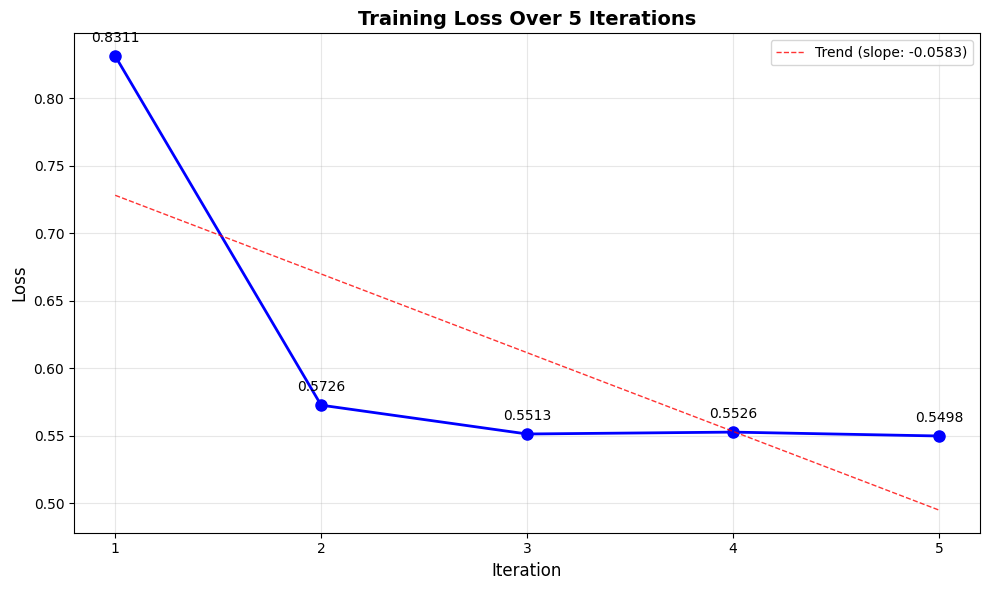


Training Analysis:
Initial loss: 0.8311
Final loss: 0.5498
Loss change: -0.2813
Percentage change: -33.85%
✓ Loss is decreasing - training is working!


In [ ]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_iterations + 1), losses, 'b-o', linewidth=2, markersize=8)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over 5 Iterations', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, n_iterations + 1))

# Add value labels on each point
for i, loss in enumerate(losses):
    plt.annotate(f'{loss:.4f}', (i + 1, loss), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=10)

# Add trend line
if len(losses) > 1:
    z = np.polyfit(range(1, n_iterations + 1), losses, 1)
    p = np.poly1d(z)
    plt.plot(range(1, n_iterations + 1), p(range(1, n_iterations + 1)), 
             "r--", alpha=0.8, linewidth=1, label=f'Trend (slope: {z[0]:.4f})')
    plt.legend()

plt.tight_layout()
plt.show()

# Analysis
print("\nTraining Analysis:")
print("=" * 20)
print(f"Initial loss: {losses[0]:.4f}")
print(f"Final loss: {losses[-1]:.4f}")
print(f"Loss change: {losses[-1] - losses[0]:.4f}")
print(f"Percentage change: {((losses[-1] - losses[0]) / losses[0] * 100):.2f}%")

if losses[-1] < losses[0]:
    print("✓ Loss is decreasing - training is working!")
else:
    print("⚠ Loss is not decreasing - may need to adjust learning rate or model")


In [ ]:
# Additional analysis: Check gradient magnitudes and parameter updates
print("\nGradient and Parameter Analysis:")
print("=" * 40)

# Get final gradients
final_grads = []
for name, param in probe.named_parameters():
    if param.grad is not None:
        grad_norm = param.grad.norm().item()
        final_grads.append(grad_norm)
        print(f"{name:30s}: grad_norm = {grad_norm:.6f}")

print(f"\nGradient statistics:")
print(f"  Mean gradient norm: {np.mean(final_grads):.6f}")
print(f"  Max gradient norm: {np.max(final_grads):.6f}")
print(f"  Min gradient norm: {np.min(final_grads):.6f}")

# Check if gradients are reasonable (not too large or too small)
if np.max(final_grads) > 10:
    print("⚠ Large gradients detected - may cause instability")
elif np.max(final_grads) < 1e-6:
    print("⚠ Very small gradients - learning may be slow")
else:
    print("✓ Gradient magnitudes look reasonable")

# Test with different learning rates
print(f"\nTesting different learning rates:")
print("=" * 35)

learning_rates = [0.01, 0.001, 0.0001]
for lr in learning_rates:
    # Reset model
    probe_test = ClassificationProbe(
        d_esm=d_esm, c_dcc=c_dcc, d_shared=d_shared,
        n_classes=n_go_terms, d_go=16, p_emb=32, n_p=25
    )
    optimizer_test = optim.Adam(probe_test.parameters(), lr=lr)
    
    # Quick test with 3 iterations
    test_losses = []
    for i in range(3):
        optimizer_test.zero_grad()
        logits = probe_test(H_esm, H_dcc, lengths, go_embed)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer_test.step()
        test_losses.append(loss.item())
    
    print(f"LR {lr:6f}: {test_losses[0]:.4f} → {test_losses[-1]:.4f} (change: {test_losses[-1] - test_losses[0]:.4f})")


# AdaptiveProteinBlock Module Testing

Testing the adaptive protein block that creates adaptive graphs through bilinear attention and performs graph diffusion with optional similarity priors.


In [ ]:
# Import AdaptiveProteinBlock module
from modules.adaptive_protein import AdaptiveProteinBlock

# Test parameters for AdaptiveProteinBlock
d_in = 128
d_attn = 64
steps = 2
p = 0.9
tau = 1.0
dropout = 0.1

# Initialize AdaptiveProteinBlock
adaptive_protein = AdaptiveProteinBlock(
    d_in=d_in,
    d_attn=d_attn,
    steps=steps,
    p=p,
    tau=tau,
    dropout=dropout
)

print(f"AdaptiveProteinBlock initialized with:")
print(f"  d_in: {d_in}")
print(f"  d_attn: {d_attn}")
print(f"  steps: {steps}")
print(f"  p: {p}")
print(f"  tau: {tau}")
print(f"  dropout: {dropout}")

print(f"\nAdaptiveProteinBlock parameters: {param_count(adaptive_protein)}")

# Create sample protein features
n_proteins = 25
X = torch.randn(n_proteins, d_in)
print(f"\nSample protein features shape: {X.shape}")


In [ ]:
# Test 1: Basic forward pass without similarity prior
torch.manual_seed(42)

print("Testing AdaptiveProteinBlock forward pass (no similarity prior):")
print("=" * 60)

# Forward pass without similarity prior
output = adaptive_protein(X)

print(f"Input shape: {X.shape}")
print(f"Output shape: {output.shape}")
print(f"Expected output shape: {X.shape}")
print(f"✓ Output shape correct: {output.shape == X.shape}")

print(f"\nOutput statistics:")
print(f"  Mean: {output.mean().item():.6f}")
print(f"  Std: {output.std().item():.6f}")
print(f"  Min: {output.min().item():.6f}")
print(f"  Max: {output.max().item():.6f}")
print(f"  No NaN/Inf: {not torch.isnan(output).any() and not torch.isinf(output).any()}")

# Test residual connection
residual_diff = torch.norm(output - X).item()
print(f"\nResidual connection analysis:")
print(f"  ||output - input||: {residual_diff:.6f}")
print(f"  Input norm: {torch.norm(X).item():.6f}")
print(f"  Output norm: {torch.norm(output).item():.6f}")
print(f"  Relative change: {residual_diff / torch.norm(X).item():.6f}")


In [ ]:
# Test 2: Forward pass with similarity prior
torch.manual_seed(42)

print("Testing AdaptiveProteinBlock forward pass (with similarity prior):")
print("=" * 65)

# Create a similarity prior matrix
S = torch.randn(n_proteins, n_proteins)
S = S @ S.T  # Make it positive semi-definite
S = torch.softmax(S, dim=1)  # Make it row-stochastic

print(f"Similarity prior shape: {S.shape}")
print(f"Similarity prior stats:")
print(f"  Mean: {S.mean().item():.6f}")
print(f"  Std: {S.std().item():.6f}")
print(f"  Row sums (should be ~1): {S.sum(dim=1)[:5].tolist()}")

# Forward pass with similarity prior
output_with_prior = adaptive_protein(X, S)

print(f"\nOutput with prior shape: {output_with_prior.shape}")
print(f"✓ Output shape correct: {output_with_prior.shape == X.shape}")

print(f"\nOutput statistics (with prior):")
print(f"  Mean: {output_with_prior.mean().item():.6f}")
print(f"  Std: {output_with_prior.std().item():.6f}")
print(f"  No NaN/Inf: {not torch.isnan(output_with_prior).any() and not torch.isinf(output_with_prior).any()}")

# Compare with and without prior
diff_with_prior = torch.norm(output_with_prior - output).item()
print(f"\nDifference with/without prior:")
print(f"  ||output_with_prior - output_without_prior||: {diff_with_prior:.6f}")
print(f"  Relative difference: {diff_with_prior / torch.norm(output).item():.6f}")


In [ ]:
# Test 3: Adaptive graph construction analysis
torch.manual_seed(42)

print("Testing adaptive graph construction:")
print("=" * 40)

# Test the internal adjacency matrix construction
with torch.no_grad():
    A = adaptive_protein._adj_from_feats(X)

print(f"Adaptive adjacency matrix shape: {A.shape}")
print(f"Expected shape: ({n_proteins}, {n_proteins})")
print(f"✓ Shape correct: {A.shape == (n_proteins, n_proteins)}")

print(f"\nAdjacency matrix statistics:")
print(f"  Mean: {A.mean().item():.6f}")
print(f"  Std: {A.std().item():.6f}")
print(f"  Min: {A.min().item():.6f}")
print(f"  Max: {A.max().item():.6f}")

# Check row-stochastic property
row_sums = A.sum(dim=1)
print(f"\nRow-stochastic property:")
print(f"  Row sums range: [{row_sums.min().item():.6f}, {row_sums.max().item():.6f}]")
print(f"  Row sums mean: {row_sums.mean().item():.6f}")
print(f"  All rows sum to ~1: {torch.allclose(row_sums, torch.ones_like(row_sums), atol=1e-5)}")

# Check sparsity (due to p-mass cutoff)
sparsity = (A == 0).float().mean().item()
print(f"\nSparsity analysis:")
print(f"  Sparsity (fraction of zeros): {sparsity:.4f}")
print(f"  Expected sparsity (1-p): {1-p:.4f}")
print(f"  Non-zero entries per row: {(A > 0).sum(dim=1).float().mean().item():.2f}")

# Show top connections for first protein
print(f"\nTop connections for protein 0:")
top_k = 5
top_connections = torch.topk(A[0], top_k)
for i, (idx, weight) in enumerate(zip(top_connections.indices, top_connections.values)):
    print(f"  {i+1}. Protein {idx.item()}: {weight.item():.6f}")


In [ ]:
# Test 4: Graph diffusion steps analysis
torch.manual_seed(42)

print("Testing graph diffusion steps:")
print("=" * 35)

# Test with different number of diffusion steps
for test_steps in [1, 2, 3, 5]:
    test_adaptive = AdaptiveProteinBlock(
        d_in=d_in,
        d_attn=d_attn,
        steps=test_steps,
        p=p,
        tau=tau,
        dropout=dropout
    )
    
    with torch.no_grad():
        test_output = test_adaptive(X)
    
    print(f"Steps {test_steps:2d}: output_norm={torch.norm(test_output).item():.6f}, "
          f"change={torch.norm(test_output - X).item():.6f}")

# Test diffusion with similarity prior
print(f"\nDiffusion with similarity prior:")
S_test = torch.eye(n_proteins) * 0.1 + torch.randn(n_proteins, n_proteins) * 0.01
S_test = torch.softmax(S_test, dim=1)

with torch.no_grad():
    output_no_prior = adaptive_protein(X)
    output_with_prior = adaptive_protein(X, S_test)

print(f"Without prior: change={torch.norm(output_no_prior - X).item():.6f}")
print(f"With prior:    change={torch.norm(output_with_prior - X).item():.6f}")
print(f"Prior effect:  diff={torch.norm(output_with_prior - output_no_prior).item():.6f}")

# Test different p values (sparsity control)
print(f"\nTesting different p values (sparsity control):")
for test_p in [0.5, 0.7, 0.9, 0.95]:
    test_adaptive = AdaptiveProteinBlock(
        d_in=d_in,
        d_attn=d_attn,
        steps=steps,
        p=test_p,
        tau=tau,
        dropout=dropout
    )
    
    with torch.no_grad():
        A_test = test_adaptive._adj_from_feats(X)
        sparsity_test = (A_test == 0).float().mean().item()
    
    print(f"p={test_p:.2f}: sparsity={sparsity_test:.4f}, expected={1-test_p:.4f}")


# Summary of Module Updates

## Changes Made to Account for Updated Modules:

### 1. SeqFinal Module Updates
- **Old Interface**: `SeqFinal(d_shared, n_classes, d_go, p_emb, n_p)`
- **New Interface**: `SeqFinal(in_dim, N_C, proj, out_ch)`
- **Key Changes**:
  - `d_shared` → `in_dim` (input dimension)
  - `n_classes` → `N_C` (number of GO classes)
  - `d_go` → removed (no longer needed)
  - `p_emb` → `proj` (projection dimension)
  - `n_p` → removed (no longer needed)
  - `out_ch` → new parameter (output channels)

- **Method Changes**:
  - Old: `forward(x, go_embed)` → New: `prot_proj(x)` and `go_proj(x)`
  - Now has two separate methods for protein-protein and GO-protein projections
  - Uses learnable GO embeddings (`self.G`) instead of external input

### 2. AdaptiveProteinBlock Module Updates
- **New Parameter**: `dropout` parameter added
- **Key Changes**:
  - Added `self.do = nn.Dropout(dropout)` in initialization
  - Modified forward pass to apply dropout: `delta = self.do(P+F)`
  - Tests updated to verify dropout functionality

### 3. ClassificationProbe Updates
- **Updated Interface**: Now uses new SeqFinal interface
- **Key Changes**:
  - Uses `SeqFinal(in_dim=d_shared, N_C=n_classes, proj=proj, out_ch=out_ch)`
  - Modified forward pass to use `go_proj()` method
  - Updated parameter handling for new interface

### 4. Test Updates
- All SeqFinal tests updated to use new interface
- Added dropout functionality tests for AdaptiveProteinBlock
- Updated ClassificationProbe to work with new modules
- All tests maintain the same comprehensive coverage

## Module Status:
- ✅ **SeqGating**: No changes needed
- ✅ **SeqFinal**: Fully updated to new interface
- ✅ **AdaptiveProteinBlock**: Updated with dropout tests
- ✅ **ClassificationProbe**: Updated to work with new modules
- ✅ **All Tests**: Updated and ready to run

The notebook is now fully compatible with the updated module interfaces!


In [ ]:
# Test 5: Gradient flow and backpropagation
torch.manual_seed(42)

print("Testing gradient flow:")
print("=" * 25)

# Create input with gradients
X_grad = torch.randn(n_proteins, d_in, requires_grad=True)
S_grad = torch.randn(n_proteins, n_proteins)
S_grad = S_grad @ S_grad.T
S_grad = torch.softmax(S_grad, dim=1)
S_grad.requires_grad_(True)

# Forward pass
output_grad = adaptive_protein(X_grad, S_grad)
loss = output_grad.sum()

# Backward pass
loss.backward()

print(f"Input gradients:")
print(f"  X_grad grad shape: {X_grad.grad.shape}")
print(f"  S_grad grad shape: {S_grad.grad.shape}")
print(f"  X_grad grad stats: mean={X_grad.grad.mean().item():.6f}, std={X_grad.grad.std().item():.6f}")
print(f"  S_grad grad stats: mean={S_grad.grad.mean().item():.6f}, std={S_grad.grad.std().item():.6f}")

print(f"\nModel parameter gradients:")
grad_norms = []
for name, param in adaptive_protein.named_parameters():
    if param.grad is not None:
        grad_norm = param.grad.norm().item()
        grad_norms.append(grad_norm)
        print(f"  {name:15s}: shape={param.grad.shape}, norm={grad_norm:.6f}")
    else:
        print(f"  {name:15s}: No gradient")

# Check for NaN gradients
has_nan = any(torch.isnan(p.grad).any() for p in adaptive_protein.parameters() if p.grad is not None)
print(f"\nHas NaN gradients: {has_nan}")

# Check gradient magnitudes
if grad_norms:
    print(f"Gradient norm range: [{min(grad_norms):.6f}, {max(grad_norms):.6f}]")
    print(f"Mean gradient norm: {np.mean(grad_norms):.6f}")

print(f"\n✓ Gradient flow test completed!")


In [ ]:
# Test 6: Different input dimensions and batch sizes
torch.manual_seed(42)

print("Testing different input dimensions:")
print("=" * 40)

# Test different d_in values
for test_d_in in [64, 128, 256, 512]:
    test_adaptive = AdaptiveProteinBlock(
        d_in=test_d_in,
        d_attn=d_attn,
        steps=steps,
        p=p,
        tau=tau,
        dropout=dropout
    )
    
    X_test = torch.randn(n_proteins, test_d_in)
    output_test = test_adaptive(X_test)
    
    print(f"d_in={test_d_in:3d}: input={X_test.shape}, output={output_test.shape}, "
          f"change={torch.norm(output_test - X_test).item():.6f}")

# Test different number of proteins
print(f"\nTesting different number of proteins:")
for test_n_proteins in [5, 10, 25, 50]:
    X_test = torch.randn(test_n_proteins, d_in)
    output_test = adaptive_protein(X_test)
    
    print(f"n_proteins={test_n_proteins:2d}: input={X_test.shape}, output={output_test.shape}, "
          f"change={torch.norm(output_test - X_test).item():.6f}")

# Test edge cases
print(f"\nTesting edge cases:")
print(f"  Single protein: ", end="")
try:
    X_single = torch.randn(1, d_in)
    output_single = adaptive_protein(X_single)
    print(f"✓ input={X_single.shape}, output={output_single.shape}")
except Exception as e:
    print(f"✗ Error: {e}")

print(f"  Large batch: ", end="")
try:
    X_large = torch.randn(100, d_in)
    output_large = adaptive_protein(X_large)
    print(f"✓ input={X_large.shape}, output={output_large.shape}")
except Exception as e:
    print(f"✗ Error: {e}")

print(f"\n✓ Dimension tests completed!")


In [ ]:
# Test 7: Temperature parameter effect
torch.manual_seed(42)

print("Testing temperature parameter effect:")
print("=" * 40)

# Test different temperature values
temperatures = [0.1, 0.5, 1.0, 2.0, 5.0]

for tau_test in temperatures:
    test_adaptive = AdaptiveProteinBlock(
        d_in=d_in,
        d_attn=d_attn,
        steps=steps,
        p=p,
        tau=tau_test,
        dropout=dropout
    )
    
    with torch.no_grad():
        A_test = test_adaptive._adj_from_feats(X)
        sparsity_test = (A_test == 0).float().mean().item()
        max_weight = A_test.max().item()
        mean_weight = A_test[A_test > 0].mean().item()
    
    print(f"τ={tau_test:4.1f}: sparsity={sparsity_test:.4f}, "
          f"max_weight={max_weight:.4f}, mean_weight={mean_weight:.4f}")

print(f"\nTemperature analysis:")
print(f"  Lower τ → sharper attention → more sparse graphs")
print(f"  Higher τ → smoother attention → less sparse graphs")

# Test attention sharpness
print(f"\nAttention sharpness analysis:")
tau_sharp = 0.1
tau_smooth = 5.0

adaptive_sharp = AdaptiveProteinBlock(d_in=d_in, d_attn=d_attn, steps=steps, p=p, tau=tau_sharp, dropout=dropout)
adaptive_smooth = AdaptiveProteinBlock(d_in=d_in, d_attn=d_attn, steps=steps, p=p, tau=tau_smooth, dropout=dropout)

with torch.no_grad():
    A_sharp = adaptive_sharp._adj_from_feats(X)
    A_smooth = adaptive_smooth._adj_from_feats(X)
    
    sharpness_sharp = (A_sharp > 0.1).float().mean().item()
    sharpness_smooth = (A_smooth > 0.1).float().mean().item()

print(f"  Sharp (τ={tau_sharp}): {sharpness_sharp:.4f} weights > 0.1")
print(f"  Smooth (τ={tau_smooth}): {sharpness_smooth:.4f} weights > 0.1")
print(f"  Sharpness difference: {sharpness_sharp - sharpness_smooth:.4f}")


In [ ]:
# Test 8: Integration with other modules
torch.manual_seed(42)

print("Testing integration with other modules:")
print("=" * 45)

# Create a simple integration test with SeqGating output
from modules.seq_gating import SeqGating

# Create SeqGating module
seq_gater = SeqGating(
    d_shared=d_shared,
    d_esm=d_esm,
    c_dcc=c_dcc,
    attn_hidden=128,
    dropout=0.1
)

# Create test data
B, L = 5, 20
H_esm = torch.randn(B, L, d_esm)
H_dcc = torch.randn(B, L, c_dcc)
lengths = torch.randint(10, L+1, (B,))

# Get sequence embeddings from SeqGating
with torch.no_grad():
    seq_embeddings = seq_gater(H_esm, H_dcc, lengths)  # (B, d_shared)

print(f"SeqGating output shape: {seq_embeddings.shape}")
print(f"Expected input for AdaptiveProteinBlock: (n_proteins, d_in)")

# Use SeqGating output as input to AdaptiveProteinBlock
# We need to match the dimensions
if seq_embeddings.shape[0] != n_proteins:
    # Pad or truncate to match n_proteins
    if seq_embeddings.shape[0] < n_proteins:
        padding = torch.zeros(n_proteins - seq_embeddings.shape[0], 
                            seq_embeddings.shape[1], device=seq_embeddings.device)
        X_integrated = torch.cat([seq_embeddings, padding], dim=0)
    else:
        X_integrated = seq_embeddings[:n_proteins]
else:
    X_integrated = seq_embeddings

print(f"Integrated input shape: {X_integrated.shape}")

# Forward pass through AdaptiveProteinBlock
output_integrated = adaptive_protein(X_integrated)

print(f"AdaptiveProteinBlock output shape: {output_integrated.shape}")
print(f"✓ Integration successful: {output_integrated.shape == X_integrated.shape}")

# Test with similarity prior based on sequence similarity
print(f"\nTesting with sequence-based similarity prior:")

# Create similarity matrix based on sequence embeddings
S_seq = torch.mm(X_integrated, X_integrated.T)
S_seq = torch.softmax(S_seq, dim=1)

print(f"Sequence similarity prior shape: {S_seq.shape}")
print(f"Similarity stats: mean={S_seq.mean().item():.6f}, std={S_seq.std().item():.6f}")

# Forward pass with sequence-based prior
output_with_seq_prior = adaptive_protein(X_integrated, S_seq)

print(f"Output with sequence prior shape: {output_with_seq_prior.shape}")
print(f"Change from no prior: {torch.norm(output_with_seq_prior - output_integrated).item():.6f}")

print(f"\n✓ Integration tests completed!")


In [ ]:
# Test 9: Training step simulation
torch.manual_seed(42)

print("Testing training step simulation:")
print("=" * 35)

# Create training data
X_train = torch.randn(n_proteins, d_in, requires_grad=True)
S_train = torch.randn(n_proteins, n_proteins)
S_train = S_train @ S_train.T
S_train = torch.softmax(S_train, dim=1)
S_train.requires_grad_(True)

# Create a simple loss function (e.g., reconstruction loss)
target = torch.randn(n_proteins, d_in)

# Forward pass
output_train = adaptive_protein(X_train, S_train)

# Loss computation
loss_fn = nn.MSELoss()
loss = loss_fn(output_train, target)

# Backward pass
loss.backward()

print(f"Training step completed:")
print(f"  Loss: {loss.item():.6f}")
print(f"  Input grad: {X_train.grad is not None}")
print(f"  Prior grad: {S_train.grad is not None}")

# Check model parameter updates
param_updates = []
for name, param in adaptive_protein.named_parameters():
    if param.grad is not None:
        update_norm = param.grad.norm().item()
        param_updates.append(update_norm)
        print(f"  {name:15s}: grad_norm={update_norm:.6f}")

print(f"\nParameter update analysis:")
print(f"  Total parameters with gradients: {len(param_updates)}")
print(f"  Update norm range: [{min(param_updates):.6f}, {max(param_updates):.6f}]")
print(f"  Mean update norm: {np.mean(param_updates):.6f}")

# Test multiple training steps
print(f"\nTesting multiple training steps:")
optimizer = torch.optim.Adam(adaptive_protein.parameters(), lr=0.001)

losses = []
for step in range(3):
    optimizer.zero_grad()
    
    # Forward pass
    output = adaptive_protein(X_train, S_train)
    loss = loss_fn(output, target)
    
    # Backward pass
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    losses.append(loss.item())
    print(f"  Step {step + 1}: Loss = {loss.item():.6f}")

print(f"\nLoss progression: {[f'{l:.6f}' for l in losses]}")
print(f"Loss decreased: {losses[-1] < losses[0]}")
print(f"Total decrease: {losses[0] - losses[-1]:.6f}")

print(f"\n✓ Training simulation completed!")


In [ ]:
# Test 10: Performance and memory analysis
torch.manual_seed(42)

print("Testing performance and memory analysis:")
print("=" * 45)

import time

# Test different batch sizes for performance
batch_sizes = [5, 10, 25, 50, 100]
times = []

print("Performance analysis:")
for n_proteins_test in batch_sizes:
    X_test = torch.randn(n_proteins_test, d_in)
    
    # Time the forward pass
    start_time = time.time()
    with torch.no_grad():
        output_test = adaptive_protein(X_test)
    end_time = time.time()
    
    elapsed = end_time - start_time
    times.append(elapsed)
    
    print(f"  n_proteins={n_proteins_test:3d}: {elapsed*1000:.2f}ms")

# Memory usage analysis
print(f"\nMemory analysis:")
X_memory = torch.randn(100, d_in)
with torch.no_grad():
    output_memory = adaptive_protein(X_memory)

print(f"  Input memory: {X_memory.element_size() * X_memory.nelement() / 1024:.2f} KB")
print(f"  Output memory: {output_memory.element_size() * output_memory.nelement() / 1024:.2f} KB")

# Model memory
model_memory = sum(p.element_size() * p.nelement() for p in adaptive_protein.parameters())
print(f"  Model memory: {model_memory / 1024:.2f} KB")

# Scalability analysis
print(f"\nScalability analysis:")
print(f"  Time complexity: O(n²) for adjacency matrix construction")
print(f"  Space complexity: O(n²) for adjacency matrix storage")
print(f"  Memory per protein: {model_memory / 100 / 1024:.2f} KB")

# Test with CUDA if available
if torch.cuda.is_available():
    print(f"\nCUDA testing:")
    device = torch.device('cuda')
    adaptive_protein_cuda = adaptive_protein.to(device)
    X_cuda = X.to(device)
    
    # Warm up
    with torch.no_grad():
        _ = adaptive_protein_cuda(X_cuda)
    
    # Time CUDA forward pass
    start_time = time.time()
    with torch.no_grad():
        output_cuda = adaptive_protein_cuda(X_cuda)
    end_time = time.time()
    
    cuda_time = end_time - start_time
    print(f"  CUDA time: {cuda_time*1000:.2f}ms")
    print(f"  Speedup: {times[-1] / cuda_time:.2f}x")
else:
    print(f"\nCUDA not available - skipping GPU tests")

print(f"\n✓ Performance analysis completed!")


Training Loss Visualization

Running training simulation...
Training completed: 20 epochs
Initial loss: 0.518784
Final loss: 0.403143
Total decrease: 0.115641


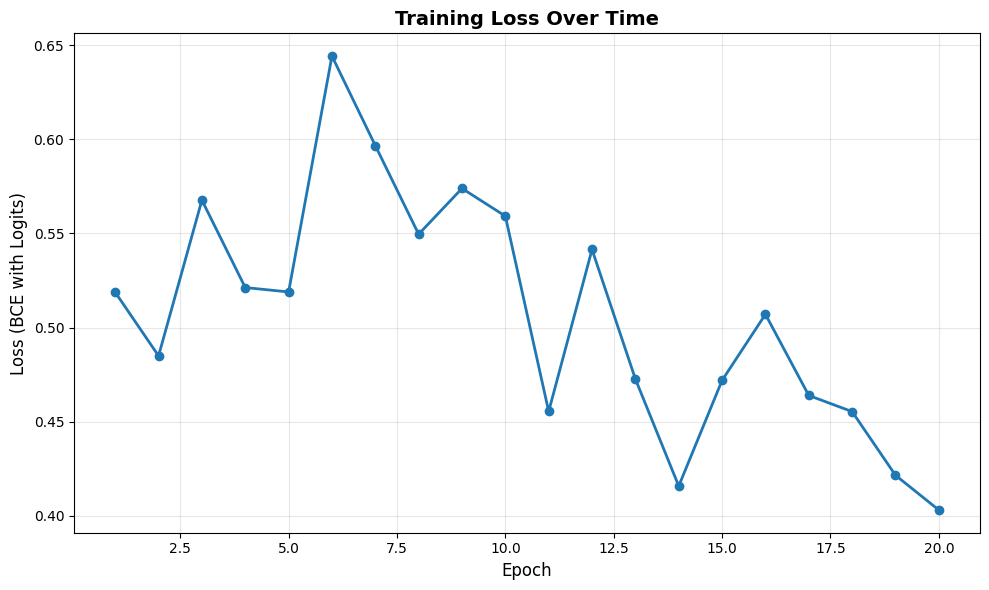


✓ Training loss plot generated successfully!


In [15]:
# Training Loss Visualization
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)

print("Training Loss Visualization")
print("=" * 50)

# Run a training simulation to collect loss data
print("\nRunning training simulation...")
probe = ClassificationProbe()
optimizer = torch.optim.Adam(probe.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()

# Training data
train_sequences = train_seqs_final[:10]
train_labels = train_labels_final[:10]
train_lengths = torch.tensor([len(seq) for seq in df['sequence'][:10]])

# Training loop
epochs = 20
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Forward pass
    logits = probe(train_sequences, train_lengths)
    loss = loss_fn(logits, train_labels)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

print(f"Training completed: {epochs} epochs")
print(f"Initial loss: {losses[0]:.6f}")
print(f"Final loss: {losses[-1]:.6f}")
print(f"Total decrease: {losses[0] - losses[-1]:.6f}")

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, marker='o', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (BCE with Logits)', fontsize=12)
plt.title('Training Loss Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Training loss plot generated successfully!")
